# クラス分類学習モデルの作成、予測の実行

In [3]:
import os
import random

# basic DS libraries
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

# plot libraries
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from seaborn_analyzer import classplot
import graphviz
import pydotplus
from IPython.display import Image
from six import StringIO

%matplotlib inline

# プログレスバー
from tqdm import tqdm

# 機械学習モデル
from sklearn.linear_model import LogisticRegression  # ロジスティック回帰
from sklearn.neighbors import KNeighborsClassifier  # K近傍法
from sklearn.svm import SVC  # サポートベクターマシン
from sklearn.tree import DecisionTreeClassifier, export_graphviz  # 決定木
from sklearn.ensemble import RandomForestClassifier  # ランダムフォレスト
from sklearn.ensemble import AdaBoostClassifier  # AdaBoost
from sklearn.naive_bayes import GaussianNB  # ナイーブ・ベイズ
from sklearn.decomposition import LatentDirichletAllocation as LDA  # 線形判別分析
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA  # 二次判別分析

# データセット分割・評価検証
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# config python file
import config

# 最大表示列数の指定（ここでは50列を指定）
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)

# ファイル保存関数（dirがなければ生成する）
def make_dir(dir_name: str):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)


# seedの固定
def fix_seed(seed: int):
    # random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)


# 再現性をもたせるためのseed固定
SEED = config.SEED
fix_seed(SEED)

In [4]:
def make_dir(dir_name: str):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)


# 特徴量チェック
def check(df):
    col_list = df.columns.values  # 列名を取得
    row = []
    for col in col_list:
        unique = ""
        value_counts = ""
        if df[col].nunique() < 12:
            unique = df[col].unique()
            value_counts = df[col].value_counts().to_dict()
        tmp = (
            col,  # 列名
            df[col].dtypes,  # データタイプ
            df[col].isnull().sum(),  # null数
            df[col].count(),  # データ数 (欠損値除く)
            df[col].nunique(),  # ユニーク値の数 (欠損値除く)
            unique,  # ユニーク値
            value_counts,  # ユニーク値のそれぞれの個数
        )
        row.append(tmp)  # tmpを順次rowに保存
    df = pd.DataFrame(row)  # rowをデータフレームの形式に変換
    df.columns = [
        "feature",
        "dtypes",
        "nan",
        "count",
        "num_unique",
        "unique",
        "unique_counts",
    ]  # データフレームの列名指定
    # unique_countsの中身確認のために横幅拡張
    d = dict(selector=".col8", props=[("min-width", "200px")])  # name
    # display(df.style.set_table_styles([d]))
    # display(df)
    return df.style.set_table_styles([d])

# 2値分類モデルの作成・実行

2値分類モデルを作成、実行し、クラス分類に有用な特徴量を見つける  
決定木以外にも、基本的な2値分類を実施できるモデルを採用し、各モデル間で比較していく。  
精度は重視しないが、accuracyよりもf1スコアを重視する。  
目的変数に偏りがある（不均衡データ、1（5年後以内に死亡）<0（5年語以内に生存））ので、**サンプリング方法を要検討**

In [5]:
df_MB_encoded = pd.read_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_DIR + "/df_MB_encoded.pkl"
)
check(df_MB_encoded)

,feature,dtypes,nan,count,num_unique,unique,unique_counts
0,LYMPH_NODES_EXAMINED_POSITIVE,float64,0,1251,27,,
1,NPI,float64,0,1251,208,,
2,CELLULARITY,int64,0,1251,3,[3 2 1],"{3: 615, 2: 500, 1: 136}"
3,CHEMOTHERAPY,int64,0,1251,2,[0 1],"{0: 972, 1: 279}"
4,INFERRED_MENOPAUSAL_STATE,int64,0,1251,2,[0 1],"{1: 952, 0: 299}"
5,AGE_AT_DIAGNOSIS,float64,0,1251,1089,,
6,GRADE,float64,0,1251,3,[3. 2. 1.],"{3.0: 665, 2.0: 492, 1.0: 94}"
7,PR_STATUS,int64,0,1251,2,[1 0],"{1: 659, 0: 592}"
8,TMB_NONSYNONYMOUS,float64,0,1251,29,,
9,ER_IHC,int64,0,1251,2,[1 0],"{1: 969, 0: 282}"


In [6]:
df_MB_encoded[df_MB_encoded.RFS_STATUS == 0]["RFS_MONTHS"]

1        83.52
3       162.76
6       162.17
8        98.22
13      161.38
         ...  
1576    133.52
1577     62.73
1578     69.61
1580    215.36
1582    142.53
Name: RFS_MONTHS, Length: 681, dtype: float64

In [7]:
print(
    "データセット全体に占める5年後の死亡者のデータの割合： ",
    df_MB_encoded[df_MB_encoded.target_OS_5years == True].shape[0]
    / df_MB_encoded.shape[0],
)

データセット全体に占める5年後の死亡者のデータの割合：  0.18784972022382093


# 学習データ分割

1. X（説明変数）とy（目的変数）に分割(y=df['target'])
2. train_test_splitによる基本的なデータ分割（train:test=75%:25%）※層化検証など他の分割手法は後で実施  

In [8]:
# Xとyに分割
X = df_MB_encoded.drop("target_OS_5years", axis=1)
y = df_MB_encoded["target_OS_5years"].astype(bool)

In [9]:
# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=config.SEED)
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
display(y_train.value_counts(), y_test.value_counts())

(938, 53)

(313, 53)

(938,)

(313,)

False    765
True     173
Name: target_OS_5years, dtype: int64

False    251
True      62
Name: target_OS_5years, dtype: int64

# 学習データの分布をプロット

オーバーサンプリング手法がどのように目的変数を生成しているのかを可視化する。  
x,y軸には以下の２パターンを描画する  
1. 3.0.0のノートブックで実施した決定木で重要度の上位に位置した特徴量（["NPI", "THREEGENE_ER-/HER2-"]）
2. float型の特徴量の中で、値がそれなりに分布している特徴量（["AGE_AT_DIAGNOSIS", "TMB_NONSYNONYMOUS"]）

## ツール
- seaborn-analyzer: https://github.com/c60evaporator/seaborn-analyzer

In [10]:
# 標準化・正規化を行う関数
def transform_normalization(df: pd.DataFrame):
    # x,y軸の特徴量の標準化
    ss = StandardScaler()
    ss.fit(df)
    df = pd.DataFrame(
        ss.transform(df),
        index=df.index,
        columns=df.columns,
    )
    return df


def transform_minmaxscaler(df: pd.DataFrame):
    # x,y軸の特徴量の標準化
    mm = MinMaxScaler()
    mm.fit(df)
    df = pd.DataFrame(
        mm.transform(df),
        index=df.index,
        columns=df.columns,
    )
    return df

In [11]:
# 散布図のプロット。targetの分類や、plot_columnsに沿った分布の様子も表記
def sns_join_plot(
    data: pd.DataFrame,
    plot_columns: list,
    target: str,
    normalization: bool = True,
    save_path: str = None,  # also need a file name
):
    df_tmp = data
    if normalization:
        df_tmp = transform_minmaxscaler(df_tmp)
    sns.jointplot(
        x=plot_columns[0],
        y=plot_columns[1],
        data=df_tmp,
        hue=target,
    )
    plt.plot()

    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()

In [12]:
# モデルとその分類結果のプロットを実施（表示する都合上、2次元なため、あくまでなんとなくの分類境界をプロットする）。
# 範囲は基本[0,1]とし、複数モデルをプロットした際に比較しやすいようにする。空白部分はテストデータの範囲のせい。
def sns_separator_plot(
    clf,
    x_columns: list,
    y_column: str,
    data: pd.DataFrame,
    normalization: bool = True,
    save_path: str = None,  # also need a file name
):
    df_tmp = data
    if normalization:
        df_tmp = transform_minmaxscaler(data)

    classplot.class_separator_plot(
        clf=clf,
        x=x_columns,
        y=y_column,
        data=df_tmp,
        # plot_scatter="class_error",
        scatter_colors=["r", "b"],
        cv=10,
        cv_seed=SEED,
        true_marker="o",
        false_marker="x",
        subplot_kws={"figsize": (7, 7)},
    )
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    if save_path:
        plt.savefig(save_path)
    else:
        plt.plot()

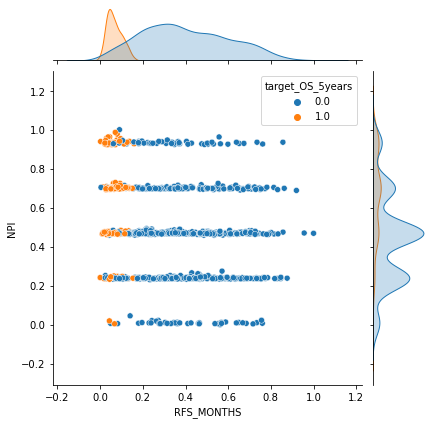

cv_number=0/10


/root/miniconda3/lib/python3.9/site-packages/seaborn_analyzer/custom_class_plot.py:252: UserWarning: You passed a edgecolor/edgecolors ('dimgrey') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(group[x_chart[0]].values, group[x_chart[1]].values,


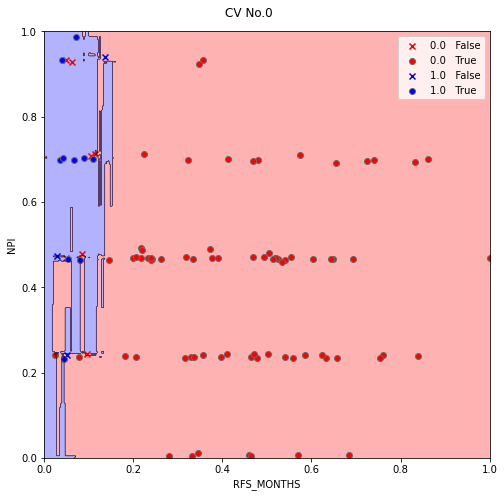

In [13]:
# 例
plot_columns = ["RFS_MONTHS", "NPI"]  # 過去に実施したモデル（決定木）で、nodeの役割を果たした特徴量
target = "target_OS_5years"
df_tmp = pd.merge(X_train, y_train, left_index=True, right_index=True)

clf = RandomForestClassifier()

sns_join_plot(df_tmp, plot_columns, target)

sns_separator_plot(
    clf=clf,
    x_columns=plot_columns,
    y_column=target,
    data=df_tmp,
)

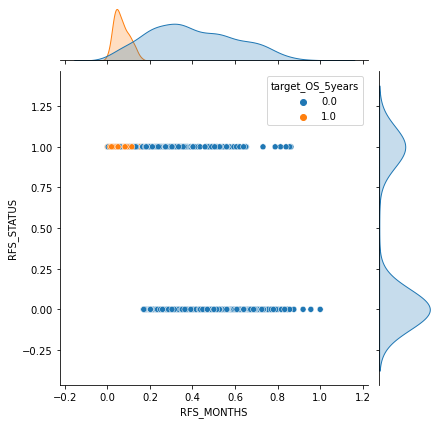

cv_number=0/10


/root/miniconda3/lib/python3.9/site-packages/seaborn_analyzer/custom_class_plot.py:252: UserWarning: You passed a edgecolor/edgecolors ('dimgrey') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(group[x_chart[0]].values, group[x_chart[1]].values,


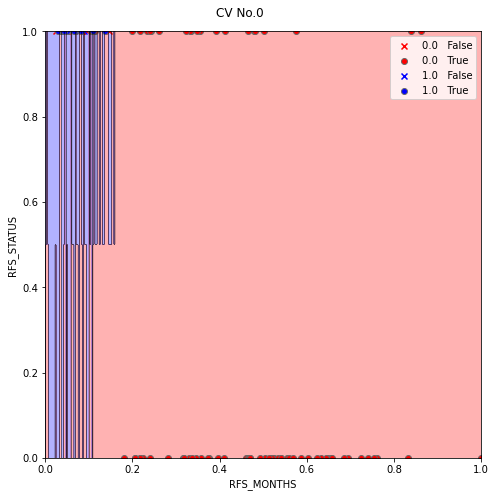

In [14]:
# 例
plot_columns = ["RFS_MONTHS", "RFS_STATUS"]  # 過去に実施したモデル（決定木）で、nodeの役割を果たした特徴量
target = "target_OS_5years"
df_tmp = pd.merge(X_train, y_train, left_index=True, right_index=True)

clf = RandomForestClassifier()

sns_join_plot(df_tmp, plot_columns, target)

sns_separator_plot(
    clf=clf,
    x_columns=plot_columns,
    y_column=target,
    data=df_tmp,
)

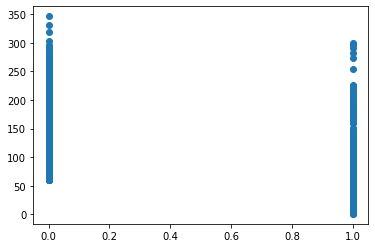

In [15]:
plt.scatter(x=df_tmp.RFS_STATUS, y=df_tmp.RFS_MONTHS)

# 2値分類モデル

In [16]:
# 基本的なスコアの表示（面倒なので関数化した）
def show_scores(y_test: pd.Series, y_pred_tree: pd.Series):
    print("accuracy: ", accuracy_score(y_test, y_pred_tree))
    print("precision: ", precision_score(y_test, y_pred_tree))
    print("recall: ", recall_score(y_test, y_pred_tree))
    print("f1 score: ", f1_score(y_test, y_pred_tree))

In [17]:
# 混合行列のプロット
def show_confusion_matrix(
    y_test: pd.Series,
    y_pred: pd.Series,
    model_name: str = "confusion matrix",
    display_details: bool = False,
):
    cm = confusion_matrix(y_test, y_pred, normalize="all", labels=[True, False])
    df_cm = pd.DataFrame(data=cm, index=[True, False], columns=[True, False])

    fig = plt.figure()
    sns.heatmap(df_cm, square=True, cbar=True, annot=True, cmap="Blues")
    plt.title(model_name)
    plt.xlabel("Predict label")
    plt.ylabel("True label")
    plt.plot()

    if display_details:
        tn, fp, fn, tp = cm.ravel()
        print("tn: ", tn, "\nfp: ", fp, "\nfn:", fn, "\ntp:", tp)
        show_scores(y_test, y_pred)

## ベースラインの精度

全てFalseと予測（学習データはFalseが多いため）した場合のスコア

False    251
True      62
Name: target_OS_5years, dtype: int64

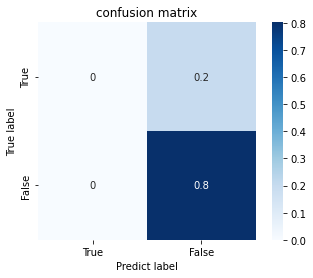

In [18]:
y_base = pd.Series([False for i in range(y_test.shape[0])], index=y_test.index)
display(y_test.value_counts())
show_confusion_matrix(y_test, y_base)

# 様々な機械学習手法の比較

様々な機械学習手法を用いて2値分類を行う。  
簡単に精度を見るため、再現性は担保されていない（引数にrandom_stateを要求しないclfもあるため）ので、必要に応じて再度モデルを構築すること。  
また、パラメータはデフォルト値を使用している。  
そのためパラメータ次第では結果が向上、下降しうる（決定木のf1など）。  

In [19]:
bcm_names = [
    "Logistic Regression",
    "Nearest Neighbors",
    "Linear SVM",
    "Polynomial SVM",
    "RBF SVM",
    "Sigmoid SVM",
    "Decision Tree",
    "Random Forest",
    "AdaBoost",
    "Naive Bayes",
    # "Linear Discriminant Analysis", # predictメソッドに対応していない
    "Quadratic Discriminant Analysis",
]

classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(),
    SVC(kernel="linear"),
    SVC(kernel="poly"),
    SVC(kernel="rbf"),
    SVC(kernel="sigmoid"),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GaussianNB(),
    # LDA(),
    QDA(),
]

メモ：ここから修正。3.0.1と比較すること

In [20]:
import warnings


def compare_bcms(
    X: pd.DataFrame(),
    y: pd.Series(),
    bcm_names: list = bcm_names,
    classifiers: list = classifiers,
    plot_columns: list = plot_columns,
    sort_column_name: str = "f1_test",
    average_time: int = 20,
    test_size: float = 0.25,
    over_sampling_class=None,
    normalization: bool = False,
):
    warnings.filterwarnings("ignore")  # lrで警告が出て視認性が悪いので、いったん非表示
    result = []

    for name, clf, local_seed in zip(
        bcm_names, classifiers, range(average_time)
    ):  # 指定したa複数の分類機を順番に呼び出す

        print(name)  # モデル名
        X_cp, y_cp = X.copy(), y.copy()

        X_train, X_test, y_train, y_test = train_test_split(
            X_cp, y_cp, test_size=test_size, random_state=local_seed
        )  # 訓練データ・テストデータの生成

        if normalization:
            # 正規化処理の実施（スケールを[0,1]に抑える）
            # 正規化を施すcolumnsの指定
            int_columns = [
                # patient
                "LYMPH_NODES_EXAMINED_POSITIVE",
            ]

            float_columns = [
                # patient
                "NPI",
                "AGE_AT_DIAGNOSIS",
                # sample
                "TUMOR_SIZE",
                "TMB_NONSYNONYMOUS",
            ]

            # trainデータにtestデータの内容を含ませないようにするため、MiMaxScaler()のsetを適用するのはtrainデータのみ
            mm = MinMaxScaler()
            mm.fit(X_train[int_columns + float_columns])
            X_train[int_columns + float_columns] = pd.DataFrame(
                mm.transform(X_train[int_columns + float_columns]),
                index=X_train[int_columns + float_columns].index,
                columns=int_columns + float_columns,
            )

            X_test[int_columns + float_columns] = pd.DataFrame(
                mm.transform(X_test[int_columns + float_columns]),
                index=X_test[int_columns + float_columns].index,
                columns=[int_columns + float_columns],
            )

        # オーバーサンプリング（trainデータのみに適用）
        if over_sampling_class:
            X_train, y_train = over_sampling_class.fit_resample(X_train, y_train)

        for _ in tqdm(range(average_time)):  # average_time 回繰り返し、指標の平均を見る
            # 訓練のスコア
            clf.fit(X_train, y_train)  # 学習
            y_pred_train = clf.predict(X_train)
            acc_train = accuracy_score(y_train, y_pred_train)
            f1_train = f1_score(y_train, y_pred_train)
            # 　予測値のスコア
            y_pred = clf.predict(X_test)
            acc_test = accuracy_score(y_test, y_pred)  # 正解率（test）の算出
            f1_test = f1_score(y_test, y_pred)
            result.append([name, acc_train, acc_test, f1_train, f1_test])  # 結果の格納
        # 混合行列の表示
        show_confusion_matrix(y_test, y_pred)

    # 表示設定
    df_result = pd.DataFrame(
        result, columns=["classifier", "acc_train", "acc_test", "f1_train", "f1_test"]
    )
    df_result_mean = (
        df_result.groupby("classifier")
        .mean()
        .sort_values(sort_column_name, ascending=False)
    )
    warnings.filterwarnings("always")
    return df_result_mean

/tmp/ipykernel_158/3359028115.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y: pd.Series(),


In [21]:
import warnings


def plot_bcm_border(
    X: pd.DataFrame(),
    y: pd.Series(),
    bcm_names: list = bcm_names,
    classifiers: list = classifiers,
    plot_columns: list = plot_columns,
    sort_column_name: str = "f1_test",
    over_sampling_class=None,
    normalization: bool = False,
    save_path: str = ".",
):

    warnings.filterwarnings("ignore")  # lrで警告が出て視認性が悪いので、いったん非表示
    result = []

    for name, clf in tqdm(zip(bcm_names, classifiers)):  # 指定した複数の分類機を順番に呼び出す
        # init
        X_cp, y_cp = X.copy(), y.copy()

        if normalization:
            # 正規化
            int_columns = [
                # patient
                "LYMPH_NODES_EXAMINED_POSITIVE",
            ]

            float_columns = [
                # patient
                "NPI",
                "AGE_AT_DIAGNOSIS",
                # sample
                "TUMOR_SIZE",
                "TMB_NONSYNONYMOUS",
            ]

            mm = MinMaxScaler()
            mm.fit(X_cp[int_columns + float_columns])
            X_cp[int_columns + float_columns] = pd.DataFrame(
                mm.transform(X_cp[int_columns + float_columns]),
                index=X_cp[int_columns + float_columns].index,
                columns=int_columns + float_columns,
            )
        if over_sampling_class:
            X_cp, y_cp = over_sampling_class.fit_resample(X_cp, y_cp)

        # プロット
        print(name)  # モデル名
        make_dir(save_path)
        sns_separator_plot(
            clf=clf,
            x_columns=plot_columns,
            y_column="target_OS_5years",
            data=pd.merge(X_cp, y_cp, left_index=True, right_index=True),
            save_path=save_path + "/" + name + ".png",
        )
    warnings.filterwarnings("always")

/tmp/ipykernel_158/1367482072.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y: pd.Series(),


Logistic Regression


100%|█████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.53it/s]


Nearest Neighbors


100%|█████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.04it/s]


Linear SVM


100%|█████████████████████████████████████████████████████████| 10/10 [00:34<00:00,  3.49s/it]


Polynomial SVM


100%|█████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.46it/s]


RBF SVM


100%|█████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.50it/s]


Sigmoid SVM


100%|█████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.06it/s]


Decision Tree


100%|█████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 22.06it/s]


Random Forest


100%|█████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.00it/s]


AdaBoost


100%|█████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.23it/s]


Naive Bayes


100%|█████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 25.14it/s]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
RBF SVM,0.924307,0.936102,0.802228,0.868421
Linear SVM,0.943497,0.942492,0.850704,0.852459
Polynomial SVM,0.902985,0.929712,0.790805,0.830769
Sigmoid SVM,0.900853,0.926518,0.730435,0.818898
Random Forest,1.000000,0.925559,1.000000,0.807432
Decision Tree,1.000000,0.923962,1.000000,0.797423
Logistic Regression,0.947761,0.932907,0.870712,0.792079
AdaBoost,0.972281,0.916933,0.925287,0.779661
Nearest Neighbors,0.945629,0.910543,0.866841,0.750000


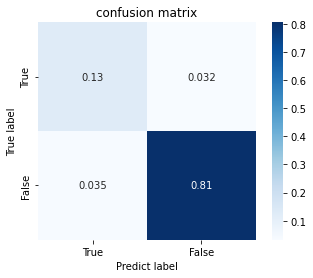

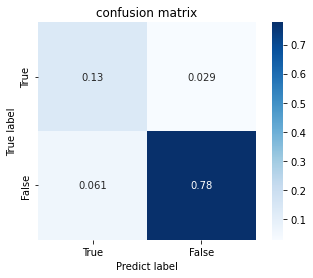

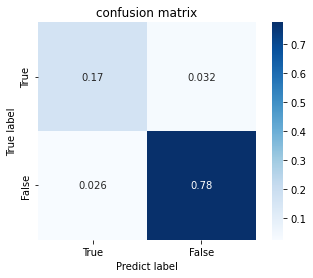

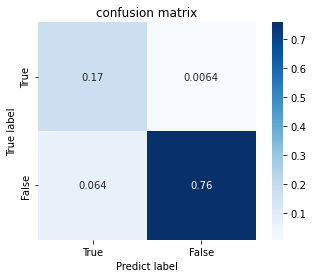

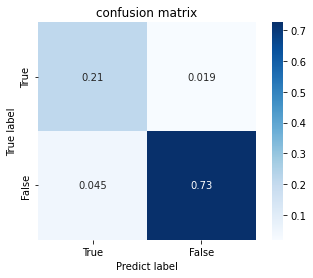

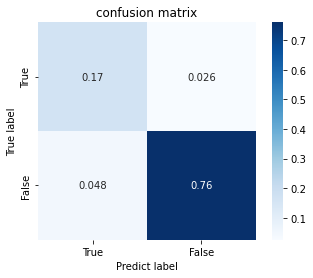

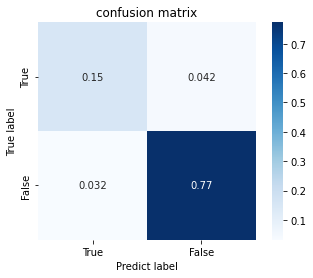

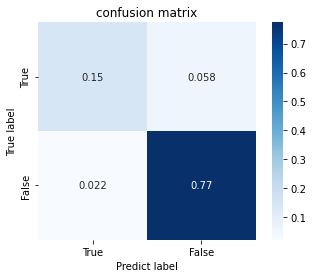

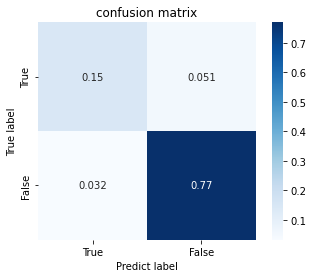

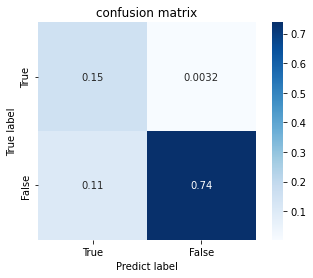

In [22]:
# 2値分類機の性能比較（パラメータ：デフォルト）
compare_bcms(X=X, y=y, average_time=10)

デフォルト値のままではf1スコアが出ない  
→全て負事例（0: 5年後も生存）で予測しているケースが多い（多少は正事例（1: 5年以内に死亡）としているケースもあるが）

2022/06/24.  
▷dropを変更したら精度向上した

0it [00:00, ?it/s]

Logistic Regression
cv_number=0/10


1it [00:01,  1.39s/it]

Nearest Neighbors
cv_number=0/10


2it [00:41, 23.92s/it]

Linear SVM
cv_number=0/10


3it [01:06, 24.67s/it]

Polynomial SVM
cv_number=0/10


4it [01:28, 23.74s/it]

RBF SVM
cv_number=0/10


5it [02:10, 30.03s/it]

Sigmoid SVM
cv_number=0/10


6it [03:04, 38.27s/it]

Decision Tree
cv_number=0/10


7it [03:05, 26.20s/it]

Random Forest
cv_number=0/10


8it [03:17, 21.59s/it]

AdaBoost
cv_number=0/10


9it [03:33, 19.89s/it]

Naive Bayes
cv_number=0/10


10it [03:35, 14.25s/it]

Quadratic Discriminant Analysis
cv_number=0/10


11it [03:37, 19.75s/it]


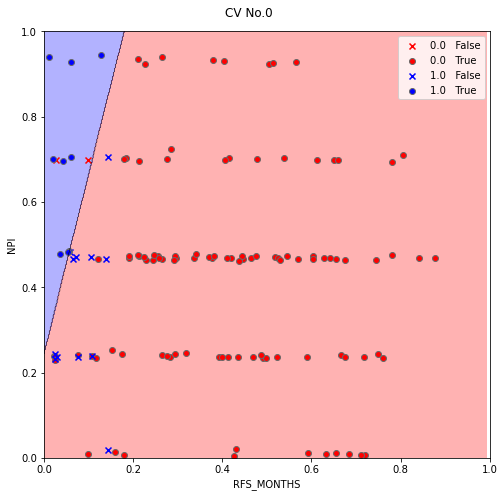

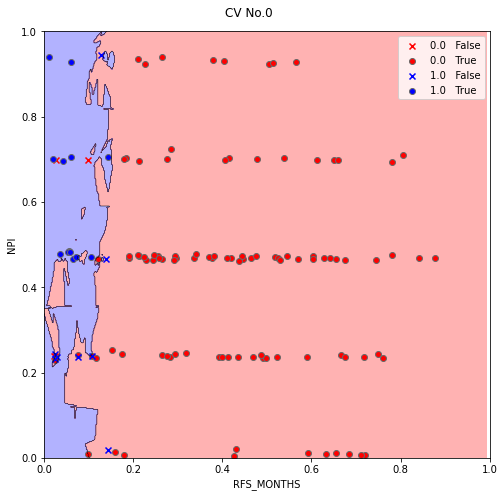

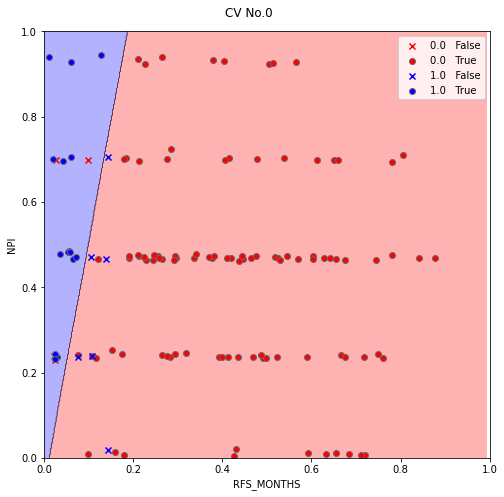

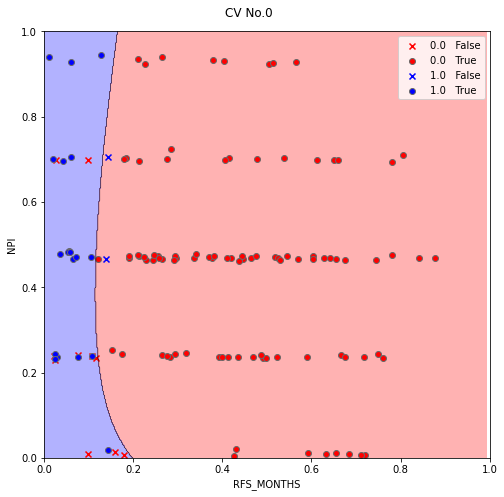

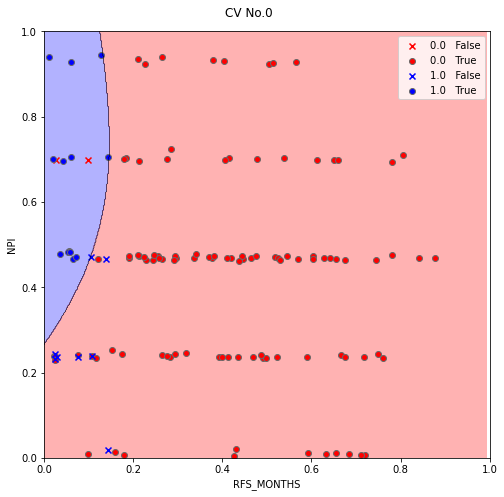

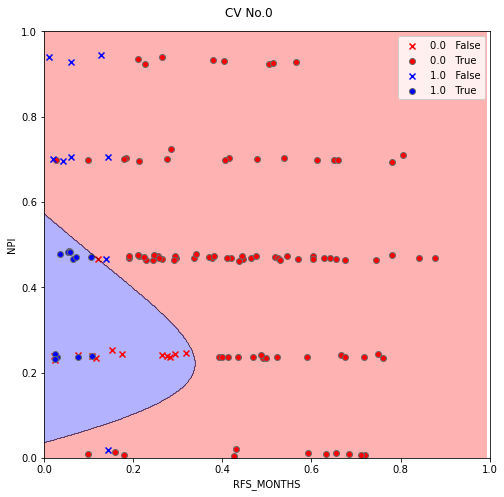

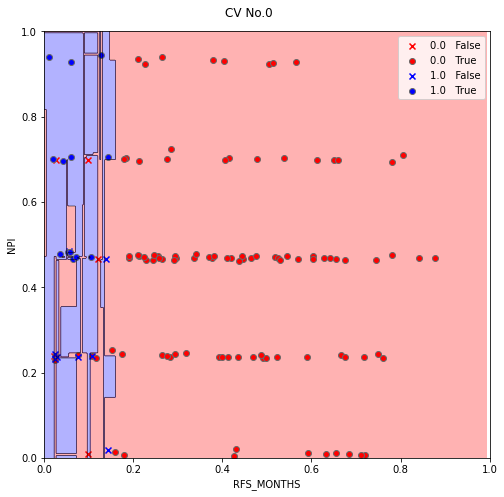

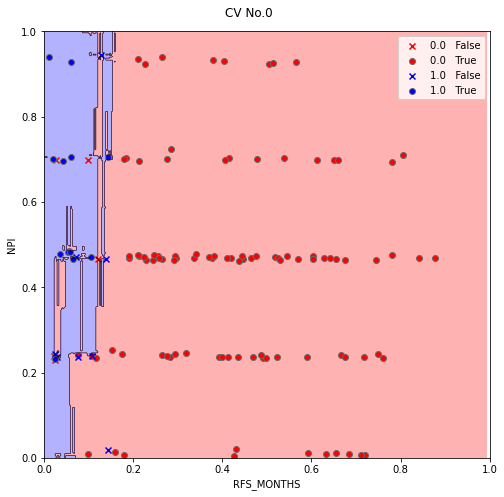

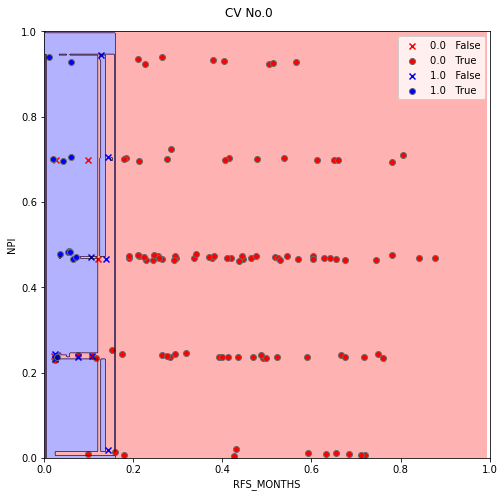

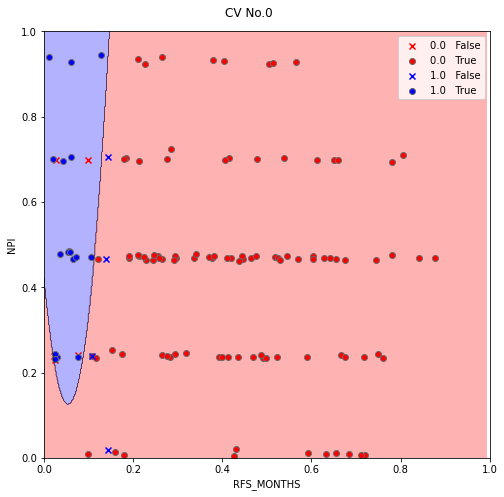

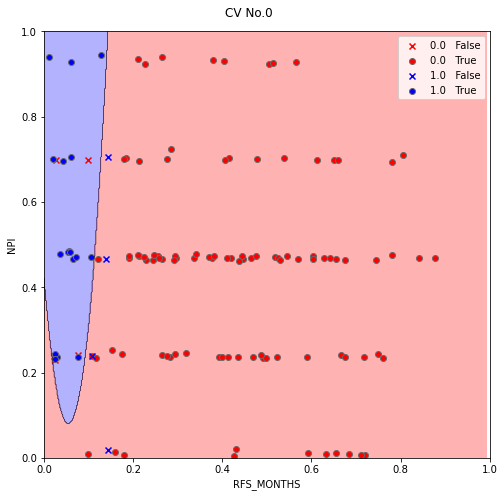

In [23]:
# plot側の内部処理でk分割交差検証を実施するので、trainとtestを結合したデータを渡す。
# ※各モデルのなんとなくの分類結果を見たい。どちらにせよ説明変数2つしか使わないので。
plot_columns = ["RFS_MONTHS", "NPI"]
plot_bcm_border(
    X=X,
    y=y,
    save_path=config.FIGURES_PROGNOSIS_SURVIVED_BCM_BASIC_DIR,
    plot_columns=plot_columns,
)

# 各モデルパラメータ調整等含む詳細な実験の実施

## ロジスティック回帰モデル

発生確率を予測する手法  
予測結果が0~1の間を取る  

In [24]:
clf_lr = LogisticRegression()
clf_lr.fit(X_train, y_train)
# 訓練データでの正答率
clf_lr.score(X_train, y_train)

/root/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9371002132196162

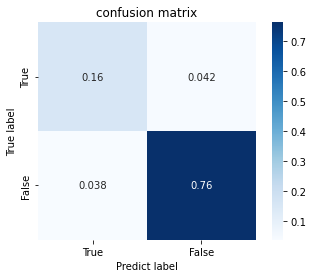

In [25]:
y_pred_lr = clf_lr.predict(X_test)
show_confusion_matrix(y_test, y_pred_lr)

## 決定木モデル
 
sklearnの決定木モデルを作成する。  
精度の高いモデルを選びたいので、葉の数を2~50まで変動させ、accuracyを見る

## 決定木モデルの構築・検証

決定木モデルを構築し、検証していく。  
パラメータを操作するため、forループで回し、最もスコアの高いものを見ていく。

In [26]:
import warnings

warnings.filterwarnings("ignore")  # lrで警告が出て視認性が悪いので、いったん非表示

accuracies_tree = {}
precisions_tree = {}
recalls_tree = {}
f1_scores_tree = {}

for nodes_num in range(2, 50):
    clf_tree = DecisionTreeClassifier(max_leaf_nodes=nodes_num, random_state=SEED)
    clf_tree = clf_tree.fit(X_train, y_train)

    y_pred_tree = clf_tree.predict(X_test)

    accuracies_tree[nodes_num] = accuracy_score(y_test, y_pred_tree)
    precisions_tree[nodes_num] = precision_score(y_test, y_pred_tree)
    recalls_tree[nodes_num] = recall_score(y_test, y_pred_tree)
    f1_scores_tree[nodes_num] = f1_score(y_test, y_pred_tree)

    # print("nodes_num: ", nodes_num)
    # show_scores(y_test, y_pred_tree)
    # print("----------" * 10)

warnings.filterwarnings("always")

In [27]:
accuracies_tree

{2: 0.9169329073482428,
 3: 0.9265175718849841,
 4: 0.9329073482428115,
 5: 0.9329073482428115,
 6: 0.9297124600638977,
 7: 0.9329073482428115,
 8: 0.9233226837060703,
 9: 0.9233226837060703,
 10: 0.9233226837060703,
 11: 0.9233226837060703,
 12: 0.9201277955271565,
 13: 0.9233226837060703,
 14: 0.9233226837060703,
 15: 0.9201277955271565,
 16: 0.9201277955271565,
 17: 0.9233226837060703,
 18: 0.9233226837060703,
 19: 0.9233226837060703,
 20: 0.9201277955271565,
 21: 0.9201277955271565,
 22: 0.9169329073482428,
 23: 0.9169329073482428,
 24: 0.9169329073482428,
 25: 0.9201277955271565,
 26: 0.9201277955271565,
 27: 0.9201277955271565,
 28: 0.9201277955271565,
 29: 0.9201277955271565,
 30: 0.9201277955271565,
 31: 0.9201277955271565,
 32: 0.9201277955271565,
 33: 0.9201277955271565,
 34: 0.9201277955271565,
 35: 0.9201277955271565,
 36: 0.9201277955271565,
 37: 0.9201277955271565,
 38: 0.9137380191693291,
 39: 0.9105431309904153,
 40: 0.9137380191693291,
 41: 0.9137380191693291,
 42: 0.9

'max nodes_num'

4

14

2

4

accuracy:  0.9329073482428115
precision:  0.7808219178082192
recall:  0.9193548387096774
f1_score:  0.8444444444444444


Text(0, 0.5, 'score')

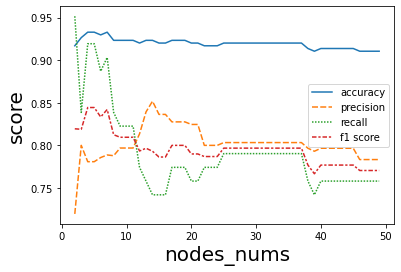

In [28]:
# 各スコアのプロット
display(
    "max nodes_num",
    max(accuracies_tree, key=accuracies_tree.get),
    max(precisions_tree, key=precisions_tree.get),
    max(recalls_tree, key=recalls_tree.get),
    max(f1_scores_tree, key=f1_scores_tree.get),
)

# f1_scoreが最も高いモデルの各スコアの表示
print(
    "accuracy: ",
    accuracies_tree[max(f1_scores_tree, key=f1_scores_tree.get)],
)
print(
    "precision: ",
    precisions_tree[max(f1_scores_tree, key=f1_scores_tree.get)],
)
print(
    "recall: ",
    recalls_tree[max(f1_scores_tree, key=f1_scores_tree.get)],
)
print(
    "f1_score: ",
    f1_scores_tree[max(f1_scores_tree, key=f1_scores_tree.get)],
)

# スコアの推移のプロット
df_score_tree = pd.DataFrame(
    [accuracies_tree, precisions_tree, recalls_tree, f1_scores_tree],
    index=["accuracy", "precision", "recall", "f1 score"],
    columns=accuracies_tree.keys(),
).T
p = sns.lineplot(data=df_score_tree)
p.set_xlabel("nodes_nums", fontsize=20)
p.set_ylabel("score", fontsize=20)

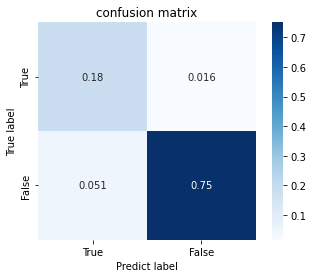

In [29]:
clf_tree = DecisionTreeClassifier(
    max_leaf_nodes=max(f1_scores_tree, key=f1_scores_tree.get),
    random_state=config.SEED,
)
clf_tree = clf_tree.fit(X_train, y_train)
y_pred_tree = clf_tree.predict(X_test)
show_confusion_matrix(y_test, y_pred_tree)

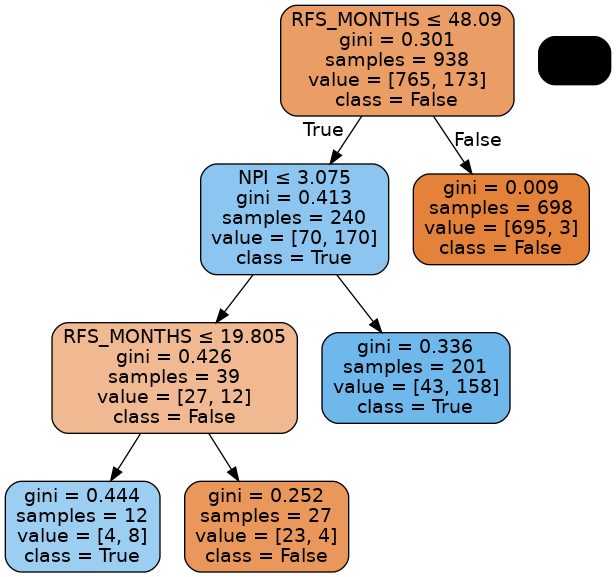

In [30]:
dot_data = StringIO()  # dotファイル情報の格納先
export_graphviz(
    clf_tree,
    out_file=dot_data,
    feature_names=X.columns,
    class_names=["False", "True"],
    filled=True,
    rounded=True,
    special_characters=True,
)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())
# graph.write_png(config.TREE_DIR + "/3.0.0-importance_dt.png")

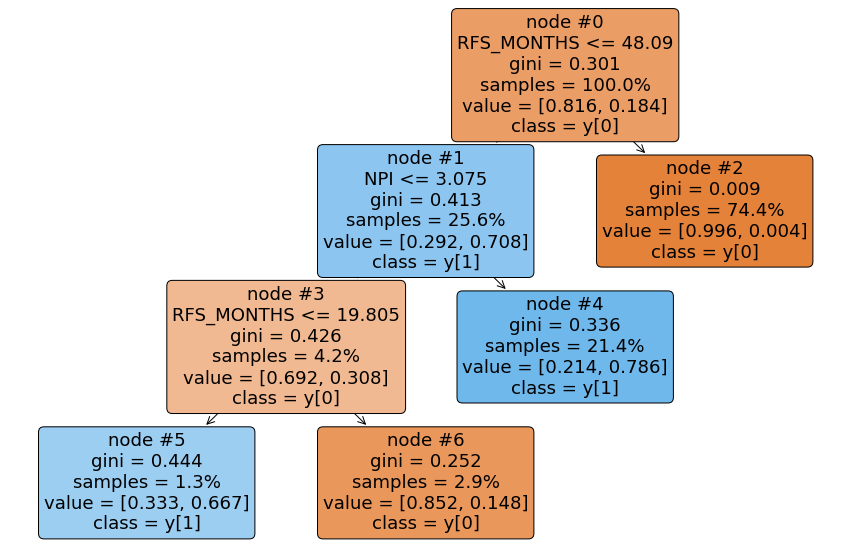

In [31]:
from sklearn.tree import plot_tree

plt.figure(figsize=(15, 10))
plot_tree(
    clf_tree,
    feature_names=X.columns,
    class_names=True,
    label="all",
    filled=True,
    impurity=True,
    node_ids=True,
    proportion=True,
    rounded=True,
)
plt.show()

# SMOTEによるオーバーサンプリング
SMOTEと呼ばれる手法によって、不均衡を低減する  
どのようにオーバーサンプリングするのか要確認

In [32]:
sm = SMOTE(random_state=SEED)

X_resampled, y_resampled = sm.fit_resample(X_train, y_train)
y_resampled.value_counts()

False    765
True     765
Name: target_OS_5years, dtype: int64

cv_number=0/10


/root/miniconda3/lib/python3.9/site-packages/seaborn_analyzer/custom_class_plot.py:252: UserWarning: You passed a edgecolor/edgecolors ('dimgrey') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(group[x_chart[0]].values, group[x_chart[1]].values,
/root/miniconda3/lib/python3.9/site-packages/seaborn_analyzer/custom_class_plot.py:252: UserWarning: You passed a edgecolor/edgecolors ('dimgrey') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(group[x_chart[0]].values, group[x_chart[1]].values,


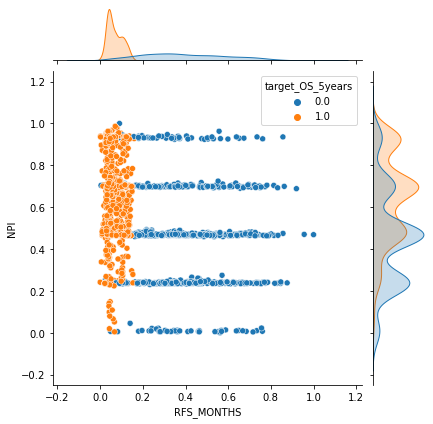

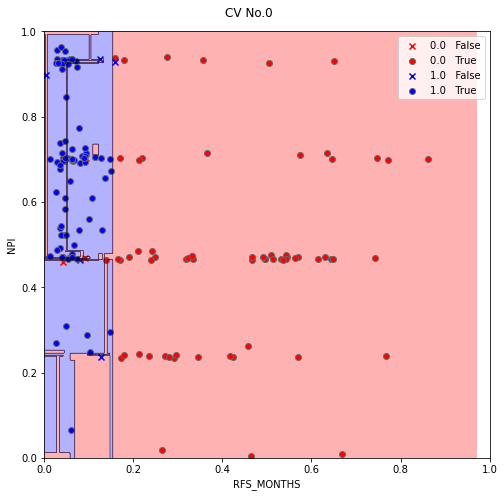

In [33]:
df_tmp = pd.merge(X_resampled, y_resampled, left_index=True, right_index=True)

save_path = (
    config.FIGURES_PROGNOSIS_SURVIVED_BCM_OVERSAMPLING_SMOTE_DIR
    + "/SMOTE_scatter("
    + plot_columns[0]
    + " x "
    + plot_columns[1]
    + ").png"
)

# SMOTE実施後の分布のプロット
sns_join_plot(
    data=df_tmp,
    plot_columns=plot_columns,
    target="target_OS_5years",
    save_path=save_path,
)

# 決定木の分類例表示（2変数の分類）
clf = DecisionTreeClassifier()
sns_separator_plot(
    clf=clf,
    x_columns=plot_columns,
    y_column="target_OS_5years",
    data=df_tmp,
    save_path=config.FIGURES_PROGNOSIS_SURVIVED_BCM_OVERSAMPLING_DIR
    + "/sample_SMOTE.png",
)

Logistic Regression


100%|█████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.74it/s]


Nearest Neighbors


100%|█████████████████████████████████████████████████████████| 10/10 [00:21<00:00,  2.11s/it]


Linear SVM


100%|█████████████████████████████████████████████████████████| 10/10 [01:21<00:00,  8.19s/it]


Polynomial SVM


100%|█████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.14s/it]


RBF SVM


100%|█████████████████████████████████████████████████████████| 10/10 [00:15<00:00,  1.50s/it]


Sigmoid SVM


100%|█████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.70s/it]


Decision Tree


100%|█████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.39it/s]


Random Forest


100%|█████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.45s/it]


AdaBoost


100%|█████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.23s/it]


Naive Bayes


100%|█████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 22.07it/s]


'\nplot_bcm_border(\n    X=X,\n    y=y,\n    over_sampling_class=SMOTE(random_state=SEED),\n    save_path=config.FIGURES_PROGNOSIS_SURVIVED_BCM_OVERSAMPLING_SMOTE_DIR,\n)\n'

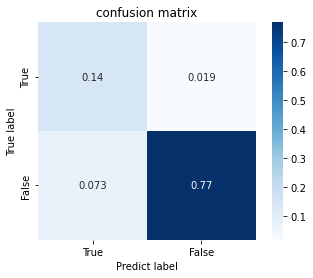

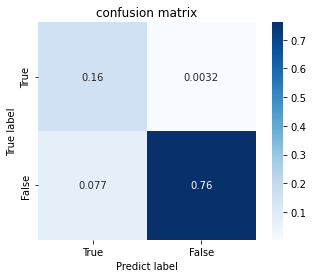

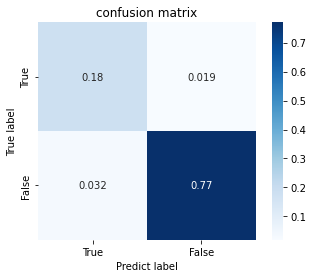

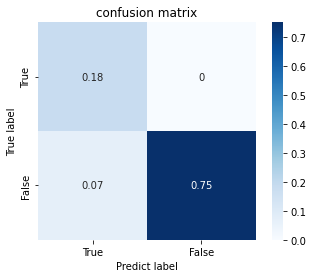

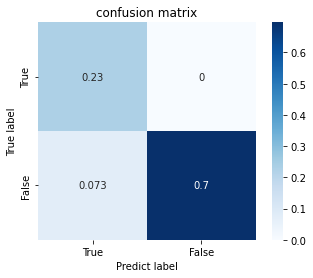

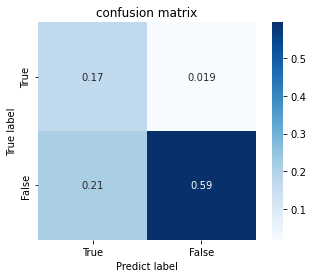

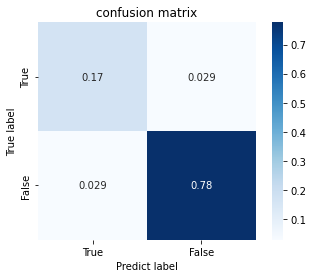

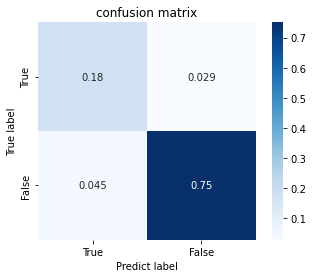

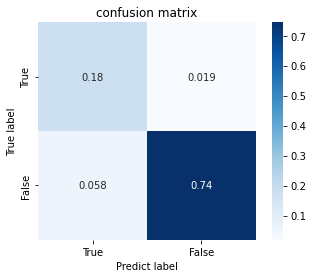

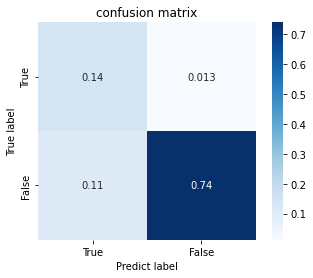

In [34]:
# オーバーサンプリングありのモデル比較
compare_bcms(
    X=X,
    y=y,
    average_time=10,
    over_sampling_class=SMOTE(random_state=SEED),
    plot_columns=plot_columns,
)

"""
plot_bcm_border(
    X=X,
    y=y,
    over_sampling_class=SMOTE(random_state=SEED),
    save_path=config.FIGURES_PROGNOSIS_SURVIVED_BCM_OVERSAMPLING_SMOTE_DIR,
)
"""

Logistic Regression


100%|█████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.78it/s]


Nearest Neighbors


100%|█████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.04s/it]


Linear SVM


100%|█████████████████████████████████████████████████████████| 10/10 [00:42<00:00,  4.25s/it]


Polynomial SVM


100%|█████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.15s/it]


RBF SVM


100%|█████████████████████████████████████████████████████████| 10/10 [00:15<00:00,  1.59s/it]


Sigmoid SVM


100%|█████████████████████████████████████████████████████████| 10/10 [00:22<00:00,  2.21s/it]


Decision Tree


100%|█████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.36it/s]


Random Forest


100%|█████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.40s/it]


AdaBoost


100%|█████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.19s/it]


Naive Bayes


100%|█████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 22.47it/s]


'\nplot_bcm_border(\n    X=X,\n    y=y,\n    over_sampling_class=SMOTE(random_state=SEED),\n    normalization=True,\n    save_path=config.FIGURES_PROGNOSIS_SURVIVED_BCM_NORMALIZATION_DIR,\n)\n'

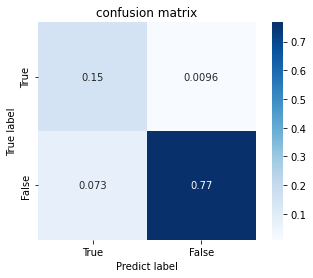

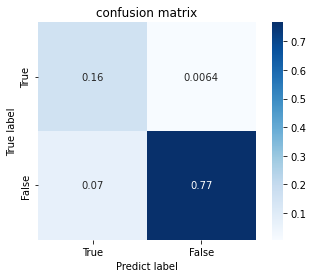

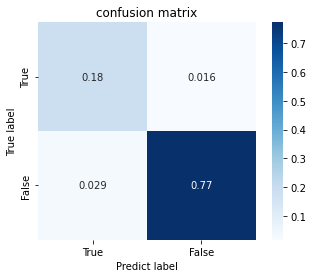

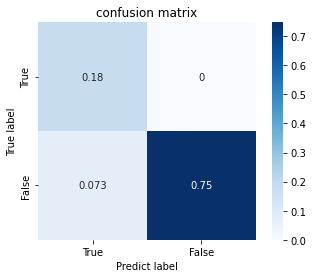

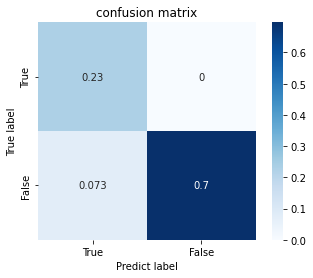

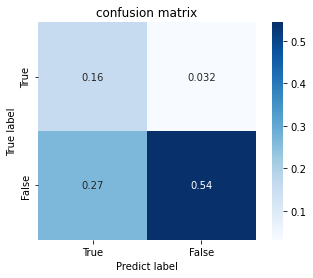

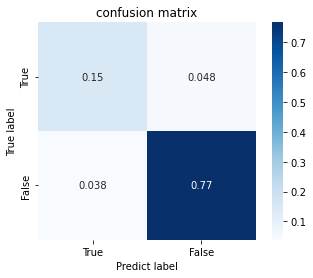

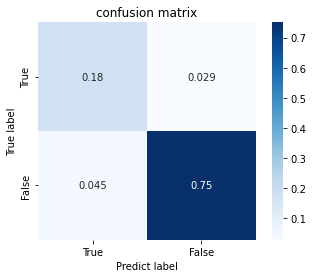

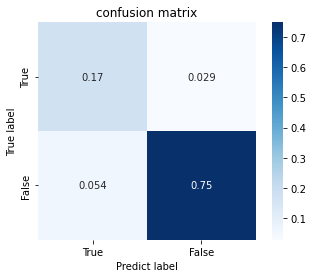

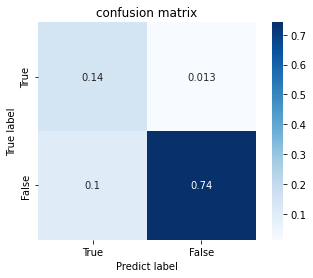

In [36]:
# オーバーサンプリングあり、正規化ありのモデル比較
compare_bcms(
    X=X,
    y=y,
    average_time=10,
    over_sampling_class=SMOTE(random_state=SEED),
    plot_columns=plot_columns,
    normalization=True,
)

"""
plot_bcm_border(
    X=X,
    y=y,
    over_sampling_class=SMOTE(random_state=SEED),
    normalization=True,
    save_path=config.FIGURES_PROGNOSIS_SURVIVED_BCM_NORMALIZATION_DIR,
)
"""